In [1]:
%reload_ext autoreload
%autoreload 2

import os
import pickle
import logging
import multiprocessing
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp

import arviz as az
import numpyro
import numpyro.distributions as dist

from hbmep.config import Config
from hbmep.model.utils import Site as site

from models import (
    MixtureModel,
    RectifiedLogistic,
    Logistic5,
    Logistic4,
    ReLU
)

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)


In [2]:
dir = "/home/vishu/repos/hbmep-paper/reports/paper/rats/J_RCML_000/model-comparison"
inference_file = "numpyro_data.nc"

model_dir = "mixture-model"
src = os.path.join(dir, model_dir, inference_file)
mixture_model = az.from_netcdf(src)

model_dir = "rectified-logistic"
src = os.path.join(dir, model_dir, inference_file)
rectified_logistic = az.from_netcdf(src)

# model_dir = "logistic-5-tighter-baseline"
# src = os.path.join(dir, model_dir, "inference.nc")
# logistic5 = az.from_netcdf(src)

model_dir = "logistic-4"
src = os.path.join(dir, model_dir, inference_file)
logistic4 = az.from_netcdf(src)

model_dir = "relu"
src = os.path.join(dir, model_dir, inference_file)
relu = az.from_netcdf(src)


In [6]:
model_dict = {
    # "Mixture Model": mixture_model,
    "Rectified Logistic": rectified_logistic,
    # "Logistic-5": logistic5,
    "Logistic-4": logistic4,
    "ReLU": relu,
    # "Saturated": relu
}

compare_df = az.compare(model_dict)
compare_df


/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Rectified Logistic,0,54445.300362,6548.778868,0.000000,0.891678,461.448301,0.000000,True,log
Logistic-4,1,50628.041894,6149.127069,3817.258469,0.076964,450.640727,113.602768,True,log
ReLU,2,42031.176754,4961.006962,12414.123609,0.031358,466.541276,167.544383,True,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

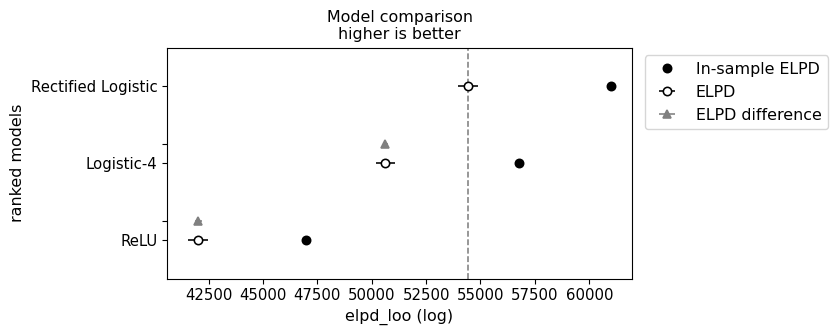

In [57]:
# compare_df = compare_df.sort_values(by="elpd_loo", ascending=False)
az.plot_compare(comp_df=compare_df, insample_dev=True)


In [25]:
compare_df = compare_df.sort_values(by="elpd_loo", ascending=True)


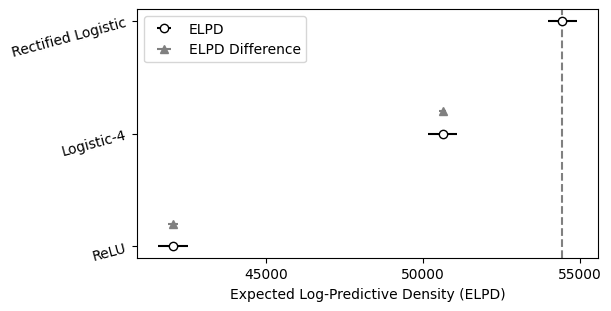

In [54]:
nrows, ncols = 1, 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 3 * nrows), squeeze=False, constrained_layout=True)

models = compare_df.index.tolist()
x = np.array([i for i in range(len(models))])

elpd_loo = compare_df["elpd_loo"].values
se = compare_df["se"].values
elpd_diff = compare_df["elpd_diff"].values
dse = compare_df["dse"].values

ax = axes[0, 0]
ax.errorbar(y=x, x=elpd_loo, fmt="o", xerr=se, ecolor="black", color="white", markeredgecolor="black", label="ELPD")
ax.axvline(elpd_loo[-1], linestyle="dashed", color="grey")
ax.errorbar(y=x[:-1] + .2, x=elpd_loo[:-1], fmt="^", xerr=dse[:-1], ecolor="grey", color="grey", markeredgecolor="grey", label="ELPD Difference")

ax.set_yticks(x)
ax.set_yticklabels(models, rotation=15)
ax.set_xlabel("Expected Log-Predictive Density (ELPD)")
# fig.suptitle("Cross validation on TMS data")
ax.xaxis.set_major_locator(plt.MaxNLocator(3))

plt.legend();
